In [1]:
import pandas as pd
import quandl
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error as mape
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import my function 
import sys
sys.path.insert(0, 'C:/Users/shuva/PycharmProjects/Py_and_R')
from Package import Arima_garch_forecasts

In [3]:
#import GDP data from FRED
df = quandl.get(dataset="FRED/GDP",  start_date='1950-01-01', end_date='2021-12-31', collapse = 'annual')
df = df.reset_index()

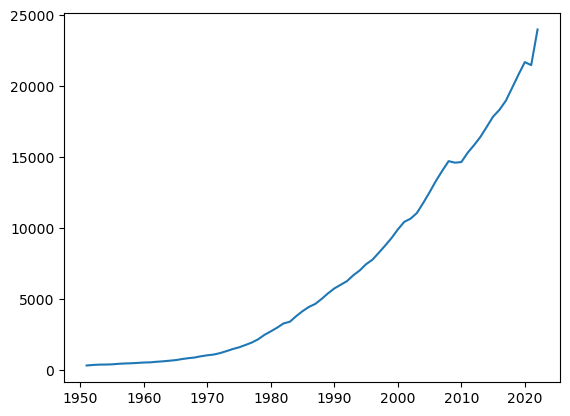

In [4]:
# draw the graph of GDP in time
plt.plot(df.Date, df.Value)

Series have several twists in overall trend in 2008 and 2020

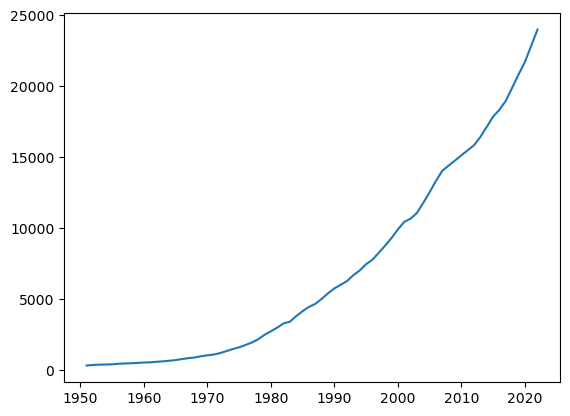

In [5]:
# let's change seeral values with Nan, since they are clogging up time series
# then we interpolate our series and plot the result
spisok = ["2007-12-31","2010-12-31","2008-12-31", "2009-12-31", "2020-12-31"]
for i in spisok:
    df.loc[df.Date==i, 'Value']=np.nan
df.Value = df.Value.interpolate()
plt.plot(df.Date, df.Value)

Now the plot of time series looks much smoother

In [6]:
# add t-variable for time trend and diide the sample into train and test one
df['t'] = range(1, df.shape[0]+1)
df_train = df.loc[df.Date.dt.year<2019, ]
df_test = df.drop(df_train.index)

In [7]:
# estimate simple OLS-regression GDP=a0+a1*t+a2*t^2+e
regr = smf.ols(data=df_train, formula = "Value~t+I(t**2)").fit()
print(regr.summary())

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.840e+04
Date:                Sat, 01 Jul 2023   Prob (F-statistic):           1.36e-97
Time:                        23:36:37   Log-Likelihood:                -466.90
No. Observations:                  69   AIC:                             939.8
Df Residuals:                      66   BIC:                             946.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    803.3448     79.902     10.054      0.0

It's a common situation when regression model on time series has autocorrelation in residuals and sometimes heteroscedasticity; knowing that we conduct formal tests for detecting heteroscedasticity and autocorrelation

In [8]:
print("prob of non-heterosced: {:.4f}".format(sms.het_goldfeldquandt(y=regr.model.endog, x = regr.model.exog, alternative = 'two-sided', split=0.2)[1], "there is heteroscedasticity"))
print("dw-stat: {:.3f}".format(sms.durbin_watson(regr.resid), "there is autocorrelation"))

prob of non-heterosced: 0.0000
dw-stat: 0.290


In [9]:
print('mape of approximation: {:.3f}'.format(mape(df_train.Value, regr.fittedvalues)))

mape of approximation: 0.110


Mape of approximation is lower than 12%-15%, that's one of indicators of good model

In [10]:
# we need to use rebust standard errors since there are heteroscedasticity and autocorrelation
print(regr.get_robustcov_results(cov_type='HAC', maxlags=1).summary())

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.183e+04
Date:                Sat, 01 Jul 2023   Prob (F-statistic):           4.64e-85
Time:                        23:36:37   Log-Likelihood:                -466.90
No. Observations:                  69   AIC:                             939.8
Df Residuals:                      66   BIC:                             946.5
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    803.3448     98.252      8.176      0.0

We may see that t-statistics became slightly lower;
Let's make a prediction on test sample

In [11]:
predictions = regr.get_prediction(df_test)
p2 = predictions.summary_frame(alpha=0.05)
p2 = p2.drop(columns = ['mean_se'])
df_test.index = p2.index
p2['true_value'] = df_test.iloc[:,1]
p2['isinci'] = np.where((p2['true_value']<=p2['obs_ci_upper'])&(p2['true_value']>=p2['obs_ci_lower']), 1,0)
print('share of true GDP values from test sample inside the prediction confidence interval: {:.3f}'.format(p2.isinci.mean()))

share of true GDP values from test sample inside the prediction confidence interval: 0.333


Only 1/3 of true test values is in prediction confidence interval, so model is not adequate enough

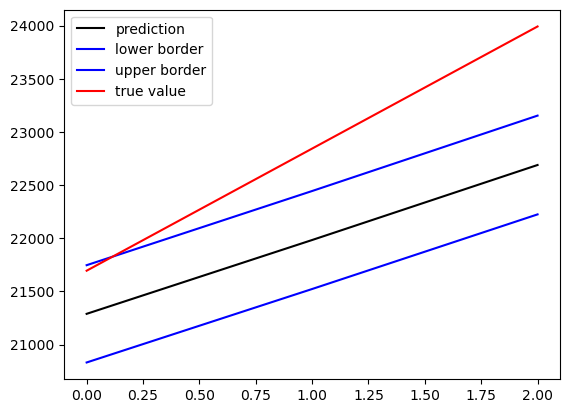

In [12]:
# plot prediction results
plt.plot(p2['mean'], label='prediction', color='black')
plt.plot(p2.obs_ci_lower, label='lower border', color='blue')
plt.plot(p2.obs_ci_upper, label='upper border', color='blue')
plt.plot(p2.true_value, label='true value', color='red')
plt.legend()
plt.show()

In [13]:
# calculate mean average precentage error
round(mape(p2['true_value'],p2['mean'] ), 3)

0.037

As we may conclude, the model has good quality since the R-square is 0.999 and significant (p-value of F-test << 0.01). But model is not adequate since only 1/3 of true GDP values from test sample inside the prediction confidence interval. However, the mape of prediction is quite low, about 3.7%, so the model can be generally used for predicting purposes, even thous some of the Hauss-Markov biases are broken (but we corrected the coveriance matrix of coefficients). The equation looks like this: GDP = 803.35 - 103.56*t + 5.66*t^2, R-sq=0.99  
Let's try to estimate a more "elevated" model such as Arima

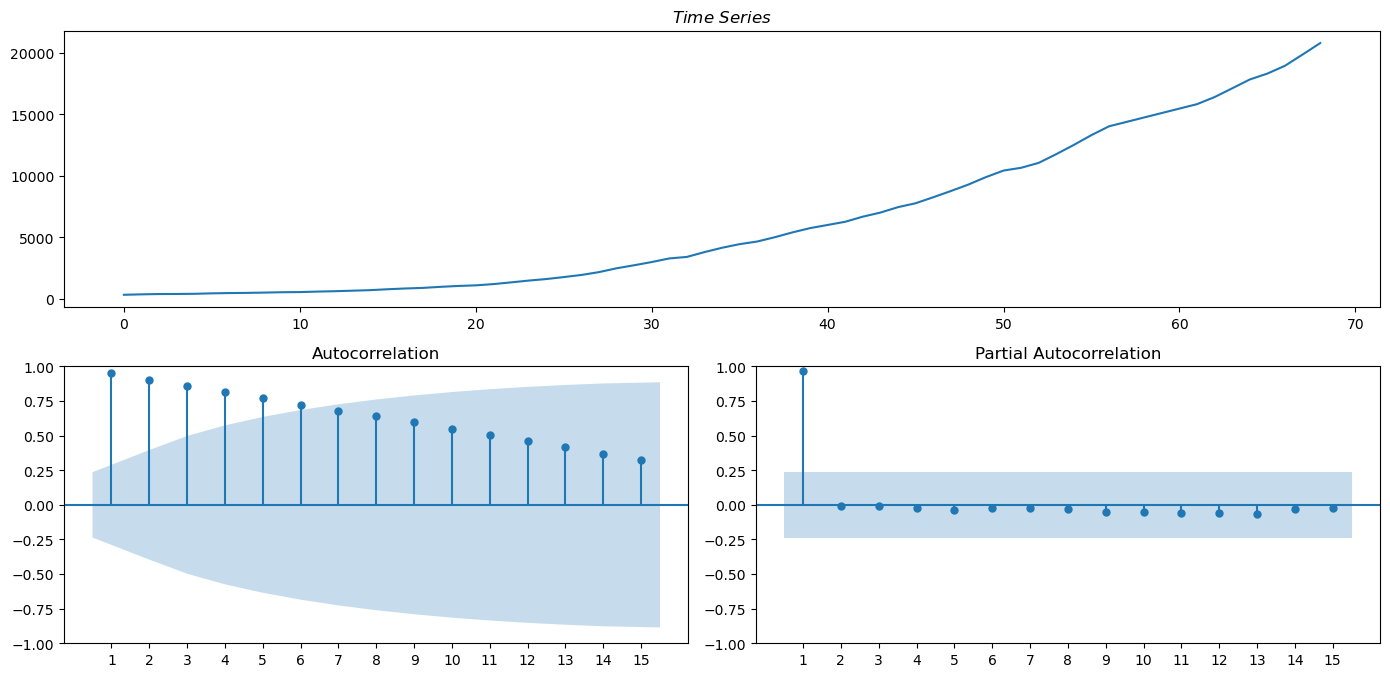

In [14]:
# let's plot the graph of series, and correlogramms
Arima_garch_forecasts.tsdisplay(df_train.Value, 15)

The data is not obviously stationary

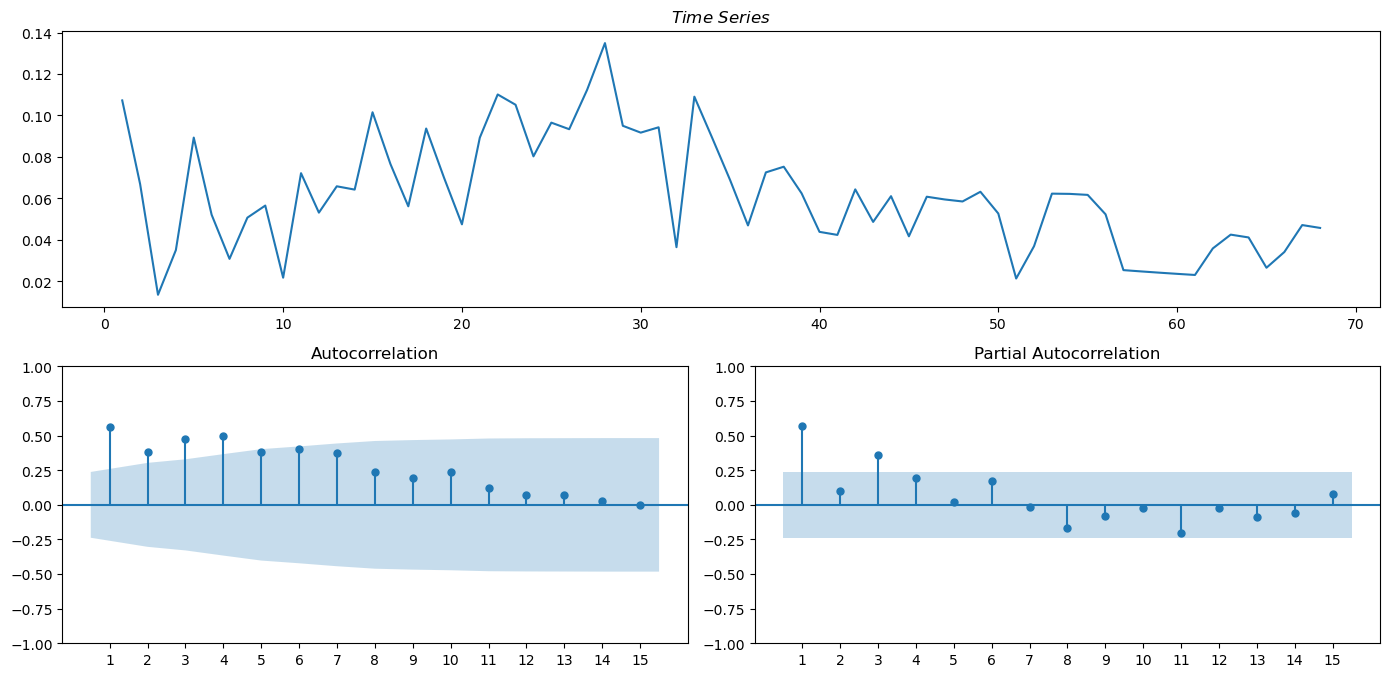

In [15]:
# let's use first differences of natural logarithms of Values, 
# since logarithm makes our data more linear, and differences make our data stationary
Arima_garch_forecasts.tsdisplay(np.log(df_train.Value).diff().dropna(), 15)

We may observe significant correlations on 1-4 lags, and significant partial correlations on 1st and 3rd lags, it's highly likely autoregressional process, not a moving average one

In [16]:
# test Dicky-Fuller for determining the stationarity of series, spoiler: they are, since p-value >> 0.1)
adfuller(np.log(df_train.Value).diff().dropna())

(-1.9611558649259235,
 0.3038601830187856,
 2,
 65,
 {'1%': -3.5352168748293127,
  '5%': -2.9071540828402367,
  '10%': -2.5911025443786984},
 -276.7559288483901)

In [17]:
# how many diff lags can we use? Definitely - first lag!
ndiffs(np.log(df_train.Value).diff().dropna())

1

In [18]:
# let's create our own Arima model, ARIMA([1,3,4], 1, 0)
arima_1 = ARIMA(np.log(df_train.Value), order=((1,0,1,1),1,0)).fit()
print(arima_1.summary())

                                 SARIMAX Results                                  
Dep. Variable:                      Value   No. Observations:                   69
Model:             ARIMA([1, 3, 4], 1, 0)   Log Likelihood                 165.669
Date:                    Sat, 01 Jul 2023   AIC                           -323.337
Time:                            23:36:39   BIC                           -314.459
Sample:                                 0   HQIC                          -319.819
                                     - 69                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4250      0.099      4.296      0.000       0.231       0.619
ar.L3          0.2888      0.123      2.345      0.019       0.047       0.530
ar.L4          0.265

In [19]:
# let's estimate auto_arima model and compare with our own
arima_auto = auto_arima(np.log(df_train.Value))
print(arima_auto.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   69
Model:               SARIMAX(2, 2, 1)   Log Likelihood                 164.427
Date:                Sat, 01 Jul 2023   AIC                           -320.855
Time:                        23:36:42   BIC                           -312.036
Sample:                             0   HQIC                          -317.365
                                 - 69                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0074      0.229      0.032      0.974      -0.441       0.456
ar.L2         -0.3405      0.152     -2.247      0.025      -0.637      -0.044
ma.L1         -0.5849      0.220     -2.659      0.0

In [20]:
# calculate forecasts
f1 = Arima_garch_forecasts.arima_forecast(arima_1, 0.05, np.log(df_test.Value))
f2 = Arima_garch_forecasts.arima_forecast(arima_auto, 0.05, np.log(df_test.Value))

In [21]:
print(mape(df_test.Value,np.exp(f1.fitted)))
print(mape(df_test.Value,np.exp(f2.fitted)))

0.016357218483283854
0.016135052095989255


Both mapes of prediction is quite low and better than that of regression model

Figure(640x480)
Figure(640x480)
Figure(640x480)


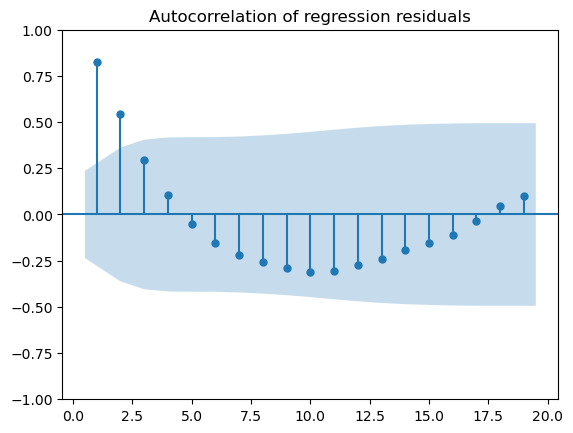

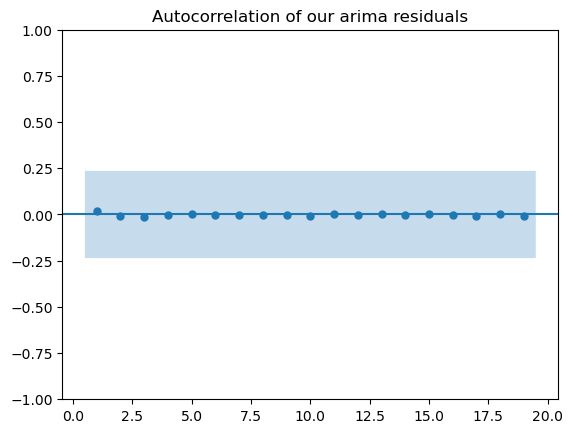

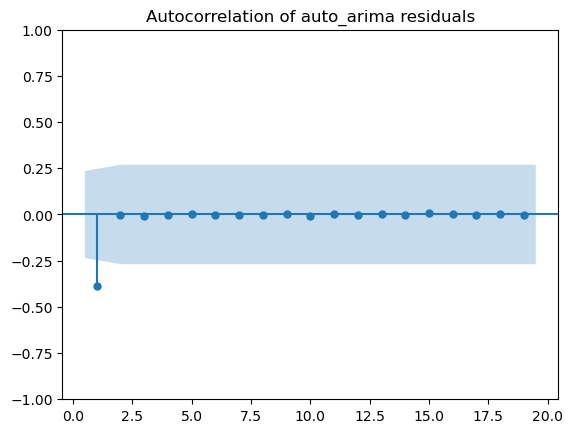

In [22]:
print(plot_acf(regr.resid, title='Autocorrelation of regression residuals', zero=0))
print(plot_acf(arima_1.resid, title='Autocorrelation of our arima residuals', zero=0))
print(plot_acf(arima_auto.resid(), title='Autocorrelation of auto_arima residuals', zero=0))

Only residuals from our arima model do not have autocorrelation, this fact means that we comprehensively described our data using our arima_1 model 

In [23]:
f1.index = range(df_train.index[-1]+1, df_train.index[-1]+2+f1.index[-1])
f2.index = range(df_train.index[-1]+1, df_train.index[-1]+2+f2.index[-1])

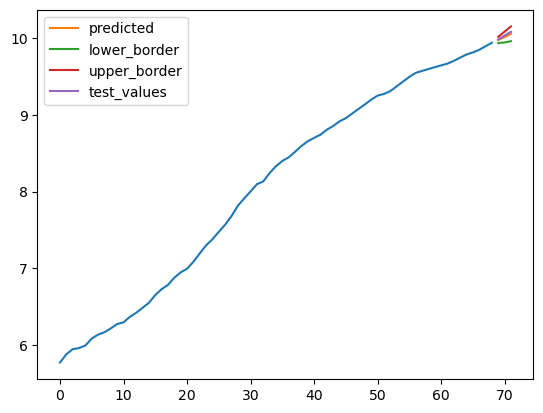

In [24]:
plt.plot(np.log(df_train.Value))
plt.plot(f1, label=['predicted', 'lower_border', 'upper_border', 'test_values'])
plt.legend()
plt.show()

All the read test GDP values are in predictive intervals, so arima_1 is statistically adequate

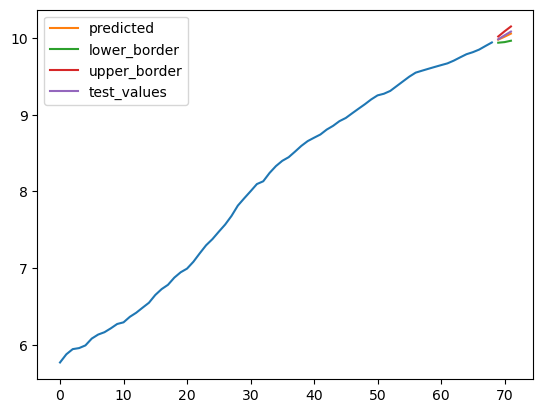

In [25]:
plt.plot(np.log(df_train.Value))
plt.plot(f2, label=['predicted', 'lower_border', 'upper_border', 'test_values'])
plt.legend()
plt.show()

All the read test GDP values are in predictive intervals, so arima_auto is statistically adequate

In [26]:
garch = arch_model(y=np.log(df_train.Value).diff().dropna(), mean='AR', lags=[1,4], p=0,o=1,q=0).fit()
print(garch.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 224601894100868.88
Iteration:      2,   Func. Count:     19,   Neg. LLF: 549.6277163797988
Iteration:      3,   Func. Count:     29,   Neg. LLF: 89.9157139182361
Iteration:      4,   Func. Count:     39,   Neg. LLF: 600773556151988.6
Iteration:      5,   Func. Count:     51,   Neg. LLF: 401.4384446995968
Iteration:      6,   Func. Count:     60,   Neg. LLF: 4341.6750908432105
Iteration:      7,   Func. Count:     69,   Neg. LLF: -70.62922734790303
Iteration:      8,   Func. Count:     78,   Neg. LLF: 85.42423707439016
Iteration:      9,   Func. Count:     86,   Neg. LLF: 20480333.511858698
Iteration:     10,   Func. Count:     94,   Neg. LLF: 62433819.67642987
Iteration:     11,   Func. Count:    102,   Neg. LLF: -161.92347135647003
Iteration:     12,   Func. Count:    109,   Neg. LLF: -161.889176142662
Iteration:     13,   Func. Count:    116,   Neg. LLF: -161.9353790130222
Iteration:     14,   Func. Count:    123,   Neg. LLF: -161

In [27]:
f3 = Arima_garch_forecasts.garch_forecast_log(garch, 0.05, df_train.Value, df_test.Value)
f3.index = range(df_train.index[-1]+1, df_train.index[-1]+2+f3.index[-1])
f3 = np.log(f3)

In [28]:
f3

,forecast,upper,lower,test
69,9.985458,10.018913,9.950844,9.984812
70,10.028219,10.097943,9.955971,10.036418
71,10.074632,10.180990,9.964357,10.085491


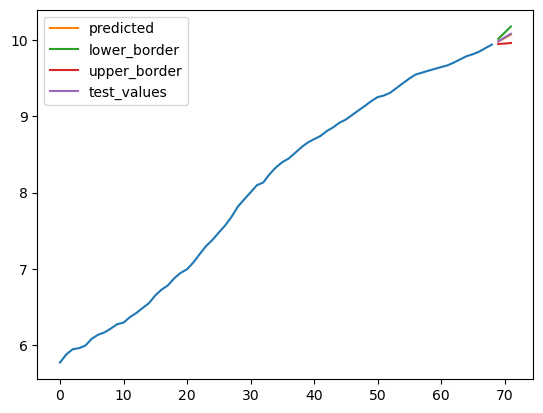

In [29]:
plt.plot(np.log(df_train.Value))
plt.plot(f3, label=['predicted', 'lower_border', 'upper_border', 'test_values'])
plt.legend()
plt.show()

All the read test GDP values are in predictive intervals, so garch model is statistically adequate  
Moreover, mape of forecast is uncomparably better than that of other models, so garch is the best model in this particular case  
Let's re-estimate the garch model on the whole dataframe and make a prediction on 2022-2024

In [30]:
garch_2 = arch_model(y=np.log(df.Value).diff().dropna(), mean='AR', lags=[1,4], p=0,o=1,q=0).fit()
print(garch.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 194116418323638.7
Iteration:      2,   Func. Count:     19,   Neg. LLF: 501439511.2847862
Iteration:      3,   Func. Count:     28,   Neg. LLF: 222912387.83707413
Iteration:      4,   Func. Count:     40,   Neg. LLF: 610.8091792911135
Iteration:      5,   Func. Count:     49,   Neg. LLF: 7148.216884959857
Iteration:      6,   Func. Count:     58,   Neg. LLF: -78.78305683094202
Iteration:      7,   Func. Count:     67,   Neg. LLF: 166.78350626084568
Iteration:      8,   Func. Count:     75,   Neg. LLF: -96.86399549669312
Iteration:      9,   Func. Count:     83,   Neg. LLF: -100.34003153970563
Iteration:     10,   Func. Count:     90,   Neg. LLF: -119.0136390404473
Iteration:     11,   Func. Count:     97,   Neg. LLF: -168.50322878732595
Iteration:     12,   Func. Count:    104,   Neg. LLF: -147.46908411594043
Iteration:     13,   Func. Count:    112,   Neg. LLF: -171.12690413122752
Iteration:     14,   Func. Count:    118,   Neg. LL

In [31]:
us_gdp_forecast = Arima_garch_forecasts.garch_forecast_without_test_log(garch_2, 0.05, df.Value, 3)
us_gdp_forecast.index = range(df.index[-1]+1, df.index[-1]+2+us_gdp_forecast.index[-1])

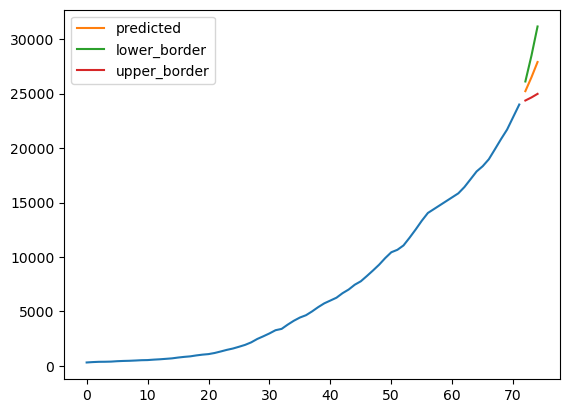

In [32]:
plt.plot(df.Value)
plt.plot(us_gdp_forecast, label=['predicted', 'lower_border', 'upper_border'])
plt.legend()
plt.show()

In [33]:
us_gdp_forecast

,forecast,upper,lower
72,25220.136677,26108.710392,24361.804335
73,26491.839091,28479.407355,24642.982548
74,27892.545148,31155.586081,24971.254683


As we see, according to the model, the US GDP will be 25220 bln dollars in 2022, 26492 bln in 2023, 27893 bln in 2024